In [38]:
import torch
import pandas as pd
import numpy as np
import os
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
%matplotlib inline




PYTORCH_CUDA_ALLOC_CONF={'max_split_size_mb':'1024','garbage_collection_threshold':'0.6'}
torch.set_printoptions(threshold=1000)

In [39]:
Dataset_dir = "../Cyclist_Detection/Dataset"

In [40]:
#Writing our Dataset class
class YoloPtDataset(torch.utils.data.Dataset):
    """Dataset with tensor format images and Yolo format labels"""

    def __init__(self,root_dir,data_type=None,transform=None):
        if data_type is None:
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a src file with the paths to all the images")
        elif data_type == 'train' or data_type == 'Train':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","train_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a train_src file with the paths to all the images")

        elif data_type == 'val' or data_type == 'Validate' or data_type == 'validate':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","val_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a val_src file with the paths to all the images")

        elif data_type == 'test' or data_type == 'Test':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","test_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a test_src file with the paths to all the images")
        else:
            raise ValueError("Wrong argument has been passed through data_type, must be one of: train,test,val")



        self.root_dir = root_dir
        #To do implement transformation
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label_path = self.paths.iloc[idx,1:].values

        sample = (torch.load(img_path),torch.load(label_path))

        if self.transform:
            sample = self.transform(sample)

        return sample

In [41]:
#Size transformation for Dataloader
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
        matched to output_size. If int, smaller of image edges is matched
        to output_size keeping aspect ratio the same.
"""
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.transformation = torchvision.transforms.Resize(size=self.output_size)

    def __call__(self, sample):
        img,label = sample[0],sample[1]

        img = self.transformation(img)

        return img,label



In [42]:
#Modyifying yolo formatted coordinates to (x_left,y_left,x_right,y_right)
def yolo_to_xy(yolo):
    _yolo = yolo.clone()
    w,h = yolo[:,2]/2,yolo[:,3]/2
    _yolo[:,0] = yolo[:,0]-w
    _yolo[:,1] = yolo[:,1]-h
    _yolo[:,2] = yolo[:,0]+w
    _yolo[:,3] = yolo[:,1]+h
    return _yolo

In [43]:
def xy_to_yolo(xy):
    if xy.shape[1] == 5:
        x1,y1,x2,y2 = xy[:,1],xy[:,2],xy[:,3],xy[:,4]
        cx = (x1 +x2)/2
        cy = (y1 + y2)/2
        w = x2 - x1
        h = y2 - y1

        return torch.stack((xy[:,0],cx,cy,w,h),axis=-1)

    elif xy.shape[1] == 4:
        x1,y1,x2,y2 = xy[:,0],xy[:,1],xy[:,2],xy[:,3]
        cx = (x1 +x2)/2
        cy = (y1 + y2)/2
        w = x2 - x1
        h = y2 - y1

        return torch.stack((cx,cy,w,h),axis=-1)

    else:
        raise ValueError(f'Wrong input shape:{xy.shape},takes [i,4] or [i,5]')



In [44]:
#Displaying a single image with bounding boxes
def Display_yolo(data,colour='green',width = 3,dtype='yolo'):

    img, label = data[0],data[1]
    resolution = img.size()[1:3]
    trans = torchvision.transforms.ToPILImage()
    img = trans(img)
    draw = ImageDraw.Draw(img)

    #Removing negative padding
    for i in range(len(label)):
        if label[i][0] == -1:
            label = label[0:i]
            break

    #Transforming to bounding box xy coordinates
    if dtype == 'yolo':
        label = yolo_to_xy(label[:,1:5])
    else:
        label = label[:,1:5]


    label[:,0],label[:,2] = label[:,0]*resolution[1],label[:,2]*resolution[1]
    label[:,1],label[:,3] = label[:,1]*resolution[0],label[:,3]*resolution[0]
    label = label.tolist()

    #Re-calculates the yolo format to top-left and bottom right points
    for i in label:
        draw.rectangle(i,outline=colour,width=width)

    display(img)

In [45]:
#Transformations:
trans = torchvision.transforms.Compose([Rescale((512,1024))])

In [46]:
#Creating dataset objects:
train = YoloPtDataset(Dataset_dir,data_type='train',transform=trans)
val = YoloPtDataset(Dataset_dir,data_type='val')
test = YoloPtDataset(Dataset_dir,data_type='test')
train_iter = torch.utils.data.DataLoader(train,batch_size=2,shuffle=True)
val_iter = torch.utils.data.DataLoader(val,batch_size=1,shuffle=False)
test_iter = torch.utils.data.DataLoader(test,batch_size=len(test),shuffle=False)

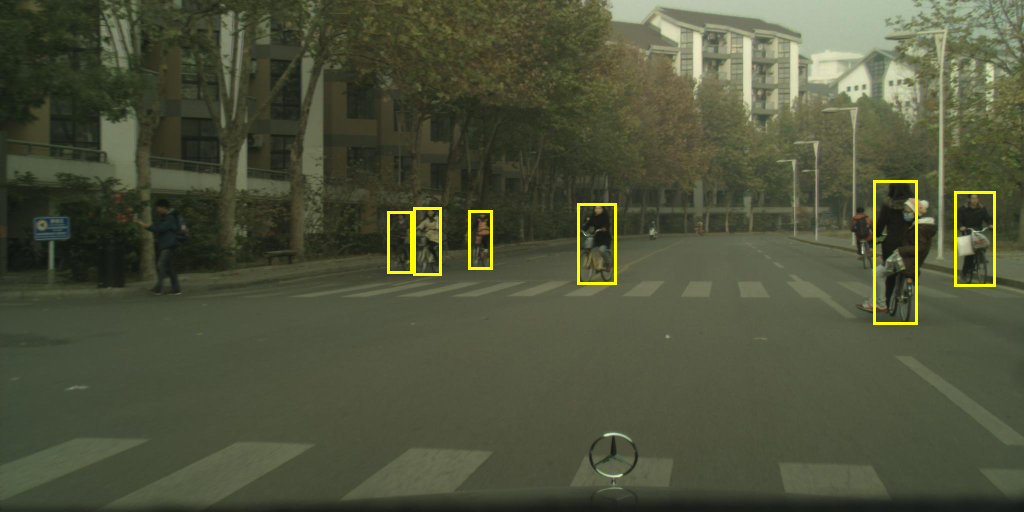

In [47]:
Display_yolo(train[402],colour='yellow')

In [ ]:
#Works correctly
#Add handling for label type "xy"
def Intersection_Over_Union(anchors,bounding_boxes,ltype='yolo'):
    if ltype == 'yolo':
        if bounding_boxes.shape[1] == 5:
            b1 = yolo_to_xy(anchors)
            b2 = yolo_to_xy(bounding_boxes[:,1:5])
            bounding_areas = bounding_boxes[:,3]*bounding_boxes[:,4]
        elif bounding_boxes.shape[1] == 4:
            b1 = yolo_to_xy(anchors)
            b2 = yolo_to_xy(bounding_boxes)
            bounding_areas = bounding_boxes[:,2]*bounding_boxes[:,3]
        else:
            raise ValueError(f'Wrong shape of input {bounding_boxes.shape}, takes input [i,5] or [i,4]')

    else:
        b1 = anchors.clone()
        b2 = bounding_boxes[:,1:5]


    inter_upperlefts = torch.max(b1[:, None, :2], b2[:, :2])
    inter_lowerrights = torch.min(b1[:, None, 2:], b2[:, 2:])



    inters = (inter_lowerrights-inter_upperlefts).clamp(min=0)
    intersection = inters[:, :, 0] * inters[:, :, 1]

    anchor_areas = anchors[:,2]*anchors[:,3]


    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = anchor_areas[:, None] + bounding_areas - inter_areas

    return inter_areas/union_areas

In [ ]:
#Works correctly
def assign_anchor_to_bbox(anchors,ground_truth,device='cpu',iou_treshold = 0.7):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = Intersection_Over_Union(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                              device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [ ]:
#Calculating offsets of two boxes
#Works correctly
def calc_offsets(anchors,bounding_boxes,eps=1e-6):
    offset_xy = 10 * (bounding_boxes[:, :2] - anchors[:, :2]) / anchors[:, 2:]
    offset_wh = 5 * torch.log(eps + bounding_boxes[:, 2:] / anchors[:, 2:])
    return torch.cat([offset_xy, offset_wh], axis=1)

In [ ]:
#Adjusting anchors' position based on their predicted offsets
#Works correctly
def offset_boxes(anchors,offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    pred_bbox_xy = (offset_preds[:, :2] * anchors[:, 2:] / 10) + anchors[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anchors[:, 2:]
    return torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)

In [ ]:
#Works correctly
def multibox_target(anchors, labels,iou_threshold = 0.5):
    """Label anchor boxes using ground-truth bounding boxes."""

    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]

    for i in range(batch_size):

        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            anchors,label[:,1:], device,iou_treshold=iou_threshold)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)

        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)

        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        # Offset transformation
        offset = calc_offsets(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
ground_truth_ = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors_ = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])
ground_truth_ = xy_to_yolo(ground_truth_)
anchors_ = xy_to_yolo(anchors_)

In [ ]:
#Non-maximum-suppression
#Works correctly
def nms(boxes,scores,iou_treshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0].to('cpu')
        keep.append(i)
        if B.numel() == 1: break
        iou = Intersection_Over_Union(boxes[i, :].reshape(-1, 4),
                    boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_treshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

def non_maximum_suppression(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):

        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)

        #Uses yolo coordinates instead of xy
        predicted_bb = offset_boxes(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)

        #Gives an output [1,num_anchors,6]
        #[0,:,0] - removal indicator yes (-1) no (1), [0,:,1] - confidence, [0,:,2:6] - yolo coordinates
    return torch.stack(out)

In [ ]:
#Works correctly
def multibox_prior(data,sizes,ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)


    # Generate all center points for the anchor boxes
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    center_w = (torch.arange(in_width, device=device) + 0.5) / in_width
    center_h = (torch.arange(in_height, device=device) + 0.5) / in_height
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    zeros_xy = torch.zeros(len(shift_x),device=device)


    # Generate all widths and heights for the anchor boxes
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))\
                    / in_height
    zeros_wh = torch.zeros(len(w),device=device)



    anchor_manipulations = torch.stack((zeros_wh, zeros_wh, w, h)).T.repeat(
        in_height * in_width, 1)

    out_grid = torch.stack([shift_x, shift_y, zeros_xy, zeros_xy],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations

    return output.unsqueeze(0)

In [ ]:
#Functions for SSD
def cls_predictor(num_inputs,priors,classes):
    return nn.Conv2d(num_inputs,priors*(classes+1),kernel_size=3,padding=1)

def offset_predictor(num_inputs,priors):
    return nn.Conv2d(num_inputs,priors*4,kernel_size=3,padding=1)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1)

def concat_pred(pred):
    return torch.cat([flatten_pred(p) for p in pred], dim=1)

In [ ]:
#Building blocks of SSD
def SSD_Conv_Block(num_inputs,num_outputs,convolutions=2,downsample=2):
    blk = []
    for _ in range(convolutions):
        blk.append(nn.Conv2d(num_inputs,num_outputs,kernel_size=3,padding=1))
        blk.append(nn.BatchNorm2d(num_outputs))
        blk.append(nn.ReLU())
        num_inputs = num_outputs
    blk.append(nn.MaxPool2d(downsample))
    return nn.Sequential(*blk)


def SSD_Base_Block(channels):
    if not isinstance(channels,list):
        raise TypeError("channels argument must be list of channels")

    blk = []
    for i in range(len(channels)-1):
        blk.append(SSD_Conv_Block(channels[i],channels[i+1]))
    return nn.Sequential(*blk)

def SSD_Block_Forward(data,blk,sizes,ratios,cls_predictor,offset_predictor):
    Y = blk(data)
    priors = multibox_prior(Y,sizes=sizes,ratios=ratios)
    cls_preds = cls_predictor(Y)
    offset_preds = offset_predictor(Y)
    return Y,priors, cls_preds, offset_preds

In [ ]:
class SSD(nn.Module):
    def __init__(self,classes,base_channels,remaining_channels,sizes,ratios,**kwargs):
        super(SSD,self).__init__(**kwargs)

        if not isinstance(base_channels,list):
            raise TypeError("base_channels argument must be list of channels")

        if not isinstance(remaining_channels,list):
            raise TypeError("remaining_channels argument must be list of channels")

        self.remaining_channels = remaining_channels
        self.sizes = sizes
        self.ratios = ratios
        self.priors = len(self.sizes[0]) + len(self.ratios[0]) - 1

        if not len(self.remaining_channels) == self.priors+1:
            raise TypeError(f'The amount of priors {self.priors+1}, does not match amount of layers {len(self.remaining_channels)}')


        self.classes = classes
        self.base_channels = base_channels



        self.blk_0 = SSD_Base_Block(self.base_channels)
        self.cls_0 = cls_predictor(self.base_channels[-1],self.priors,self.classes)
        self.ofs_0 = offset_predictor(self.base_channels[-1],self.priors)


        for i in range(len(self.remaining_channels)):

            if i == len(self.remaining_channels)-2:

                setattr(self,f'blk_{i+1}',nn.AdaptiveMaxPool2d((1,1)))
                setattr(self,f'cls_{i+1}',cls_predictor(self.remaining_channels[i+1],self.priors,self.classes))
                setattr(self,f'ofs_{i+1}',offset_predictor(self.remaining_channels[i+1],self.priors))
                self.pred_layers = i+2

                break


            setattr(self,f'blk_{i+1}',SSD_Conv_Block(self.remaining_channels[i],self.remaining_channels[i+1]))
            setattr(self,f'cls_{i+1}',cls_predictor(self.remaining_channels[i+1],self.priors,self.classes))
            setattr(self,f'ofs_{i+1}',offset_predictor(self.remaining_channels[i+1],self.priors))

    def forward(self,X):
        anchors, cls_preds,ofs_preds = [None]*self.pred_layers, [None]*self.pred_layers,[None]*self.pred_layers

        for i in range(self.pred_layers):
            X, anchors[i],cls_preds[i],ofs_preds[i] = SSD_Block_Forward(X,getattr(self,f'blk_{i}'),self.sizes[i],self.ratios[i],getattr(self,f'cls_{i}'),getattr(self,f'ofs_{i}'))

        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_pred(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0],-1,self.classes +1)
        ofs_preds = concat_pred(ofs_preds)
        return anchors,cls_preds,ofs_preds


In [ ]:
##Wrappers for our training error rates

class SSD_Error():

    def __init__(self,path=None):
        self.path = path

        if path is not None:
            if not os.path.exists(self.path):
                self.hist = None
            else:
                try:
                    self.hist = torch.load(self.path)
                except:
                    raise ValueError(f'File {path} is not of .pt format')

        else:
            self.hist = None


        self.class_error = None
        self.ofs_error = None
        self.loss = None


    @staticmethod
    def Class_error(cls_preds,cls_labels):
        return (1-float((cls_preds.argmax(dim=-1).type(
            cls_labels.dtype) == cls_labels).sum())/cls_labels.numel())

    @staticmethod
    def Ofs_error(ofs_preds, ofs_labels, ofs_masks):
        return float((torch.abs((ofs_labels - ofs_preds) * ofs_masks)).sum())/ofs_labels.numel()

    def add(self,cls_preds,cls_labels,ofs_preds,ofs_labels,ofs_masks,loss):
        if self.hist is None:

            self.class_error = SSD_Error.Class_error(cls_preds,cls_labels)
            self.ofs_error = SSD_Error.Ofs_error(ofs_preds,ofs_labels,ofs_masks)

            if isinstance(loss,float):
                self.loss = loss
            elif torch.is_tensor(loss):
                self.loss = float(loss.sum())
            else:
                raise ValueError(f'Loss argument is of wrong type {loss.__str__()}')


            self.hist = torch.tensor([[self.class_error],[self.ofs_error],[self.loss]])

        else:

            self.class_error = SSD_Error.Class_error(cls_preds,cls_labels)
            self.ofs_error = SSD_Error.Ofs_error(ofs_preds,ofs_labels,ofs_masks)

            if isinstance(loss,float):
                self.loss = loss
            elif torch.is_tensor(loss):
                self.loss = float(loss.mean())
            else:
                raise ValueError(f'loss argument is of wront type {loss.__str__()}')

            self.hist = torch.cat((self.hist,torch.tensor([[self.class_error],[self.ofs_error],[self.loss]])),dim=1)

    def save(self):
        torch.save(self.hist,self.path)

    def plot_cls_error(self):

        plt.plot(self.hist[0,:])
        plt.ylabel("Classification Error")
        plt.xlabel("Epoch")
        plt.show()

    def plot_ofs_error(self):
        plt.plot(self.hist[1,:])
        plt.ylabel("Offset Mean Absolute Error")
        plt.xlabel("Epoch")
        plt.show()

    def plot_loss(self):
        plt.plot(self.hist[2,:])
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.show()


In [ ]:
##Wrapper for our Training

class SSD_Training_Wrapper():

    def __init__(self,net,cls_loss,ofs_loss,trainer,scheduler=None,device='cpu',save_output_path=None,save_iterations=0):
        self.net = net
        self.device = device
        self.cls_loss = cls_loss
        self.ofs_loss = ofs_loss
        self.trainer = trainer
        self.scheduler = scheduler
        self.save_iteration = save_iterations
        self.epoch = 0
        self.prediction = None
        self.pimg = None


        if save_output_path is not None:
            if isinstance(save_output_path,str):
                if os.path.exists(save_output_path):
                    self.save_weights_path = os.path.join(save_output_path,"Weights.pt")
                    self.save_error_path = os.path.join(save_output_path,"Error_History.pt")

                else:
                    os.makedirs(save_output_path)
                    self.save_weights_path = os.path.join(save_output_path,"Weights.pt")
                    self.save_error_path = os.path.join(save_output_path,"Error_History.pt")

            else:
                raise ValueError(f'save_error_path should be a string, is {type(save_output_path)}')

        else:
            self.save_weights_path = save_output_path
            self.save_error_path = save_output_path

        self.error = SSD_Error(path = self.save_error_path)

    def calc_loss(self,cls_preds,cls_labels,ofs_preds,ofs_labels,ofs_masks):
        batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]

        cls = self.cls_loss(cls_preds.reshape(-1, num_classes),
                       cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
        ofs = self.ofs_loss(ofs_preds * ofs_masks,
                       ofs_labels * ofs_masks).mean(dim=1)

        return cls + ofs

    def save(self):
        if self.save_weights_path is None or self.save_error_path is None:
            raise ValueError(f'path for saving output has not been specified')
        self.net.to('cpu')

        torch.save(self.net.state_dict(),self.save_weights_path)

        self.net.to(self.device)
        self.error.save()

    def train(self,data,num_epochs,print_cls_err=True,print_ofs_err=True,ploss = True):
        self.net = self.net.to(self.device)
        self.net.train()

        for epoch in range(num_epochs):
            self.trainer.zero_grad()
            img, label = next(iter(data))
            img, label = img.to(self.device,dtype=torch.float32), label.to(self.device,dtype=torch.float32)

            anchors, cls_preds, ofs_preds = self.net(img)

            bbox_labels, bbox_masks, cls_labels = multibox_target(anchors,label)

            l = self.calc_loss(cls_preds,cls_labels,ofs_preds,bbox_labels,bbox_masks)

            l.mean().backward()
            self.trainer.step()

            if self.scheduler is not None:
                self.scheduler.step()


            self.error.add(cls_preds,cls_labels,ofs_preds,bbox_labels,bbox_masks,l)

            if self.save_weights_path is not None and self.save_error_path is not None:
                try:
                    if epoch+self.epoch % self.save_iteration == 0:
                        self.save()

                except ZeroDivisionError:
                    pass

            if print_cls_err is True or print_ofs_err or ploss is True:
                print('-------------------')
                print(f'{self.epoch + epoch+1}th epoch')
                print('===================')

            if print_cls_err is True:
                print(f'Class Error:{self.error.hist[0,-1]}')

            if print_ofs_err is True:
                print(f'Ofs Error:{self.error.hist[1,-1]}')

            if ploss is True:
                print(f'Loss:{self.error.hist[2,-1]}')

            del img
            del label

        if self.save_weights_path is not None and self.save_error_path is not None:
            self.save()

        self.epoch = self.epoch + num_epochs
        if self.device != 'cpu':
            torch.cuda.empty_cache()

    def predict(self,X):

        if isinstance(X,list):
            #Iterator will return a list
            self.pimg = X
            img = self.pimg[0].to(self.device,dtype=torch.float32)

        elif isinstance(X,tuple):
            #Dataset will return a tuple
            X = [X[0].unsqueeze(dim=0),X[1].unsqueeze(dim=0)]
            self.pimg = X
            img = self.pimg[0].to(self.device,dtype=torch.float32)

        else:
            raise TypeError('Wrong type of X argument, must be either passed directly from a dataset object or as an iterator')




        anchors, cls_preds, bbox_preds = self.net(img)


        cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
        output = non_maximum_suppression(cls_probs, bbox_preds, anchors)
        idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
        self.prediction = output[0,idx]
        return self.prediction



    def display(self,X = None,threshold = 0.9,predict_colour = 'green',true_colour = False,width=4):

        if self.pimg is None and X is None:
            raise ValueError('No image to display specified, please first use .predict() or pass the image directly to the display()')
        elif self.pimg is None:
            self.predict(X)

        if self.pimg[0].size()[0] != 1:
            raise ValueError('Cannot display multiple images, please pass one image at a time')

        img,true_label  = self.pimg[0].squeeze(dim=0),self.pimg[1].squeeze(dim=0)
        resolution = img.size()[1:]
        trans = torchvision.transforms.ToPILImage()
        img = trans(img)
        draw = ImageDraw.Draw(img)

        #Remove predictions below the threshold and keep only the coordinates
        try:
            for i in range(len(self.prediction)):
                if self.prediction[i][1] < threshold:
                    if i == 0:
                        pred_label = None
                        print('Warning: No predictions meet the threshold')
                        raise StopIteration
                    pred_label = self.prediction[:i,2:]
                    raise StopIteration

        except StopIteration:
            pass


        #Remove negative padding if we're displaying true bounding boxes
        if true_colour:
            for i in range(len(true_label)):
                if true_label[i][0] == -1:
                    true_label = true_label[:i,1:].to(device=self.device)
                    break






        #transforming yolo to xy coordinates
        if pred_label is not None:
            pred_label = yolo_to_xy(pred_label)

            pred_label[:,0],pred_label[:,2] = pred_label[:,0]*resolution[1],pred_label[:,2]*resolution[1]
            pred_label[:,1],pred_label[:,3] = pred_label[:,1]*resolution[0],pred_label[:,3]*resolution[0]
            pred_label = pred_label.tolist()




        if true_colour:
            true_label = yolo_to_xy(true_label)

            true_label[:,0],true_label[:,2] = true_label[:,0]*resolution[1],true_label[:,2]*resolution[1]
            true_label[:,1],true_label[:,3] = true_label[:,1]*resolution[0],true_label[:,3]*resolution[0]
            true_label = true_label.tolist()



        #Drawing the bounding boxes
        if pred_label is not None:
            for i in pred_label:
                draw.rectangle(i,outline=predict_colour,width=width)

        if true_colour:
            for i in true_label:
                draw.rectangle(i,outline=true_colour,width=width)

        display(img)





In [ ]:
#Evaluation of class error
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

#Evaluation of offset error
def ofs_eval(ofs_preds, ofs_labels, ofs_masks):
    return float((torch.abs((ofs_labels - ofs_preds) * ofs_masks)).sum())

In [ ]:
#Calculating Loss
def object_rec_loss(cls_preds,cls_labels,ofs_preds,ofs_labels,ofs_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    ofs = ofs_loss(ofs_preds * ofs_masks,
                     ofs_labels * ofs_masks).mean(dim=1)
    return cls + ofs

In [ ]:
#Setting temporary parameters

cls_loss = nn.CrossEntropyLoss(reduction='none')
ofs_loss = nn.L1Loss(reduction='none')

num_epochs = 5

temp_sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
              [0.88, 0.961]]
temp_ratios = [[1, 2, 0.5]] * 5
temp_net = SSD(1,[3,16,32,64],[64,128,128,128,128],temp_sizes,temp_ratios).to('cuda:0')

temp_trainer = torch.optim.SGD(temp_net.parameters(), lr=0.2, weight_decay=5e-4)

In [ ]:
temp_net.train()

training_1_dir = '../Cyclist_Detection/Training_1/Error_hist.pt'
training_2_dir = '../Cyclist_Detection/Training_1/Error_History.pt'

In [ ]:
SSD_Test_Training = SSD_Training_Wrapper(temp_net,cls_loss,ofs_loss,temp_trainer,device='cuda:0',save_output_path='../Cyclist_Detection/Training_1/',save_iterations=5)

In [ ]:
SSD_Test_Training.train(train_iter,15)

In [ ]:
temp_predict = SSD_Test_Training.predict(train[402])

In [ ]:
SSD_Test_Training.display(threshold=0.7,true_colour='yellow')